In [78]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from sklearn import preprocessing
from scipy import stats

from mlxtend.plotting import plot_decision_regions

from ast import literal_eval

import warnings

from collections import OrderedDict

from lob_data_utils import lob, model, roc_results, gdf_pca, lob_classify, stocks
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = 'data/prepared'
should_savefig = False

In [160]:
stocks_lengths = []
for stock in stocks.all_stocks:
    if stock in ['11390', '4695', '7843']:
        continue
    df, df_test = lob.load_prepared_data(stock, include_test=True)
    mid_price_counts = df['mid_price_indicator'].value_counts()
    test_mid_price_counts = df_test['mid_price_indicator'].value_counts()
    properties = {
        'mean_mid_price': df['mid_price'].mean(),
        'mean_spread': (df['ask_price'] - df['bid_price']).mean(),
        'mid_price_indicator_ratio': mid_price_counts[1] / mid_price_counts[0],
        'test_mean_mid_price': df_test['mid_price'].mean(),
        'test_mid_price_indicator_ratio': test_mid_price_counts[1] / test_mid_price_counts[0],
        'test_mean_spread': (df_test['ask_price'] - df_test['bid_price']).mean(),
    }
    stocks_lengths.append(
        {'stock': stock, 'train_length': len(df), 'test_length': len(df_test), **properties})
df_stocks = pd.DataFrame(stocks_lengths)
df_stocks['diff_mean_mid_price'] = np.abs(df_stocks['mean_mid_price'] - df_stocks['test_mean_mid_price'])
df_stocks['diff_mid_price_indicator_ratio'] = np.abs(
    df_stocks['mid_price_indicator_ratio'] - df_stocks['test_mid_price_indicator_ratio'])
df_stocks['diff_mean_spread'] = np.abs(df_stocks['mean_spread'] - df_stocks['test_mean_spread'])

In [161]:
df_stocks.describe()

,mean_mid_price,mean_spread,mid_price_indicator_ratio,test_length,test_mean_mid_price,test_mean_spread,test_mid_price_indicator_ratio,train_length,diff_mean_mid_price,diff_mid_price_indicator_ratio,diff_mean_spread
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,1314.524080,1.031760,0.401647,4960.948980,1343.709213,1.024314,0.404224,19838.775510,55.617900,0.034692,0.076848
std,1065.011971,0.863415,0.179214,1.812741,1106.226176,0.922006,0.172243,7.967111,72.992077,0.035115,0.122826
min,75.765586,0.025592,0.160573,4954.000000,75.722262,0.021665,0.128526,19808.000000,0.043324,0.000069,0.000253
25%,412.874170,0.283857,0.247764,4961.000000,433.275626,0.265068,0.262362,19837.000000,13.515903,0.012303,0.014747
50%,1097.408696,0.889807,0.375122,4961.000000,1175.162651,0.785506,0.371769,19840.000000,28.237017,0.023457,0.035117
75%,1759.486126,1.607078,0.543873,4961.000000,1801.578205,1.574944,0.525100,19844.000000,70.347467,0.045553,0.094569
max,5128.616356,5.644103,0.845610,4964.000000,5495.714574,6.563193,0.832964,19844.000000,367.098218,0.225560,0.919090


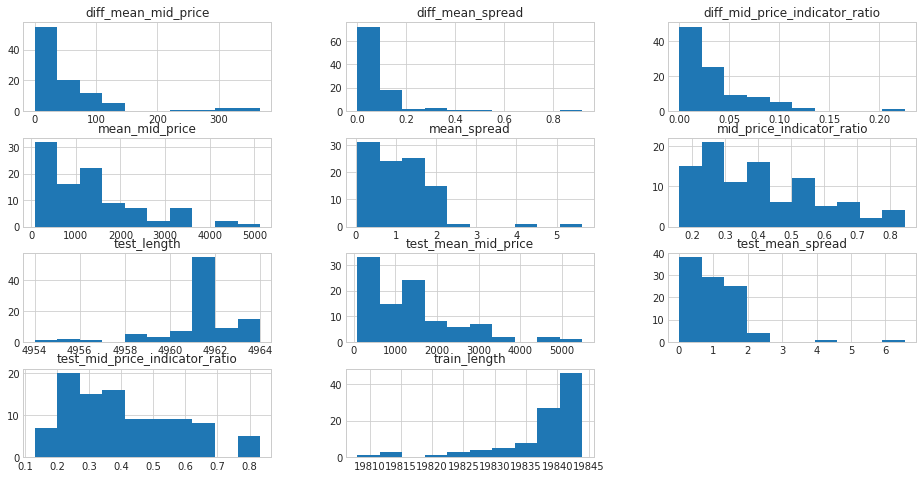

In [162]:
axes = df_stocks.hist(figsize=(16, 8))

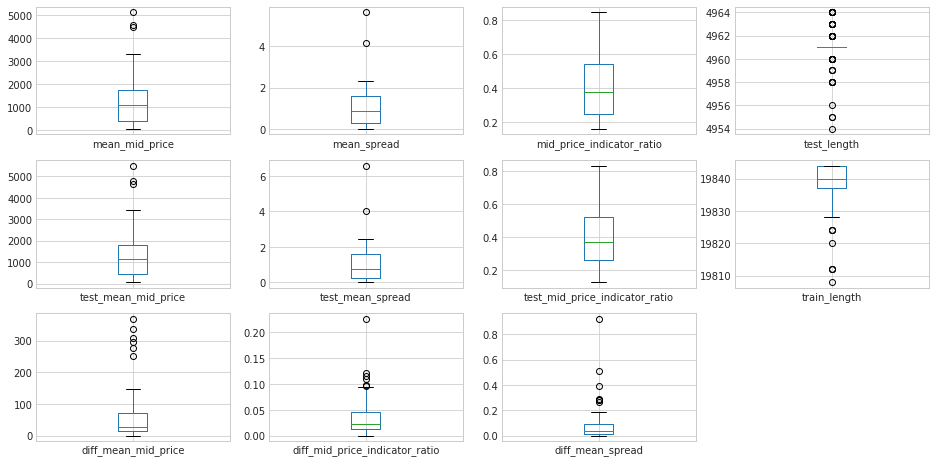

In [163]:
axes = df_stocks.plot(kind='box', subplots=True, layout=(3,4), figsize=(16, 8))

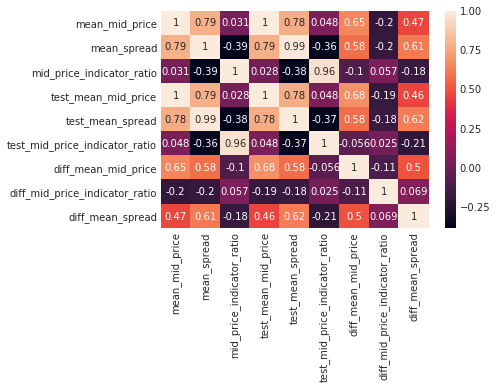

In [164]:
sns.heatmap(df_stocks[[c for c in df_stocks.columns if 'len' not in c]].corr(), annot=True)

In [189]:
df_stocks.head()

,mean_mid_price,mean_spread,mid_price_indicator_ratio,stock,test_length,test_mean_mid_price,test_mean_spread,test_mid_price_indicator_ratio,train_length,diff_mean_mid_price,diff_mid_price_indicator_ratio,diff_mean_spread,km,is_choosen
0,367.034464,0.104092,0.671214,9269,4961,363.673695,0.086414,0.556323,19844,3.360769,0.114892,0.017678,2,0
1,393.727832,0.207660,0.460191,3022,4961,400.495152,0.163616,0.528977,19844,6.767320,0.068785,0.044044,2,0
2,1289.914819,1.282359,0.189021,2051,4962,1305.862757,1.258767,0.201211,19840,15.947938,0.012190,0.023592,0,0
3,2456.725912,1.200665,0.399732,3879,4961,2485.251562,1.175973,0.428571,19844,28.525650,0.028839,0.024693,1,0
4,3134.476857,1.174032,0.685265,10166,4961,3213.383945,1.239367,0.661642,19844,78.907088,0.023624,0.065335,1,0


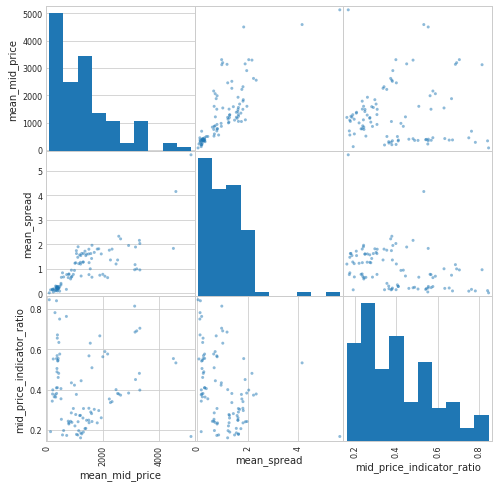

In [165]:
axes = scatter_matrix(
    df_stocks[[c for c in df_stocks.columns if 'len' not in c and 'test' not in c and 'diff' not in c]], 
    figsize=(8, 8))

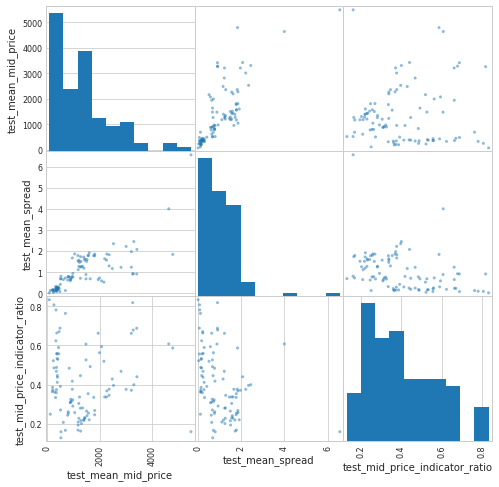

In [166]:
axes = scatter_matrix(
    df_stocks[[c for c in df_stocks.columns if 'len' not in c and 'test' in c and 'diff' not in c]], 
    figsize=(8, 8))

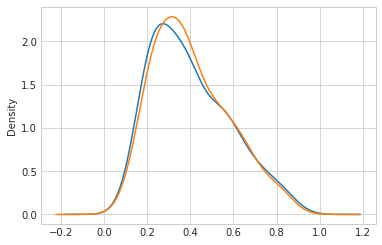

In [167]:
df_stocks['mid_price_indicator_ratio'].plot(kind='kde')
df_stocks['test_mid_price_indicator_ratio'].plot(kind='kde')

For most of the stocks the classes are inbalanced!

In [168]:
df_stocks.sort_values(by=['mid_price_indicator_ratio'], ascending=False).head(5)

,mean_mid_price,mean_spread,mid_price_indicator_ratio,stock,test_length,test_mean_mid_price,test_mean_spread,test_mid_price_indicator_ratio,train_length,diff_mean_mid_price,diff_mid_price_indicator_ratio,diff_mean_spread
83,75.765586,0.025592,0.845610,9064,4961,75.722262,0.021665,0.832964,19844,0.043324,0.012646,0.003927
85,333.112014,0.116947,0.840646,11244,4961,332.133678,0.098660,0.780969,19844,0.978336,0.059676,0.018288
28,3120.336399,0.966438,0.814060,9062,4961,3266.279933,0.917456,0.818182,19844,145.943535,0.004122,0.048982
18,279.191700,0.104359,0.781648,9069,4961,253.523398,0.091282,0.806922,19844,25.668303,0.025273,0.013077
87,686.151230,0.167577,0.762971,9061,4961,691.633824,0.131546,0.763242,19844,5.482594,0.000271,0.036031


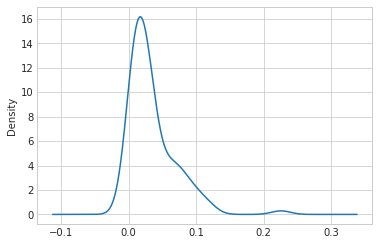

In [169]:
df_stocks['diff_mid_price_indicator_ratio'].plot(kind='kde')

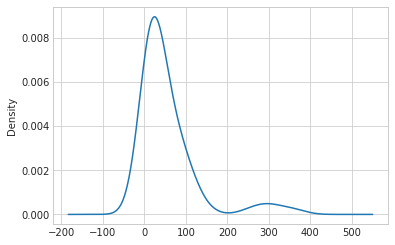

In [170]:
df_stocks['diff_mean_mid_price'].plot(kind='kde')

## Lets cluster

In [171]:
km = cluster.KMeans(n_clusters=3)
cols = ['mean_mid_price', 'mean_spread']
df_stocks['km'] = km.fit_predict(df_stocks[cols])

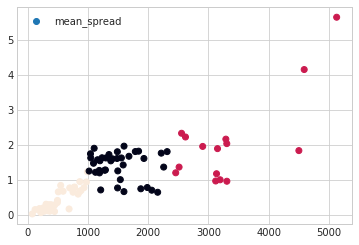

In [172]:
plt.scatter(x=df_stocks['mean_mid_price'], y=df_stocks['mean_spread'], c=df_stocks['km'])
plt.legend()

### Choosing stocks

3 representative stocks one from each cluster.

5 stocks per cluster.

In [182]:
choosen_stocks1 = df_stocks[df_stocks['km'] == 2].sort_values(
    by='diff_mid_price_indicator_ratio', ascending=True).head(5)['stock'].values
choosen_stocks2 = df_stocks[df_stocks['km'] == 1].sort_values(
    by='diff_mid_price_indicator_ratio', ascending=True).head(5)['stock'].values
choosen_stocks3 = df_stocks[df_stocks['km'] == 0].sort_values(
    by='diff_mid_price_indicator_ratio', ascending=True).head(5)['stock'].values
choosen_stocks = np.concatenate([choosen_stocks1, choosen_stocks2, choosen_stocks3])

In [187]:
is_choosen = []
for i, row in df_stocks.iterrows():
    if row['stock'] in choosen_stocks:
        is_choosen.append(1)
    else:
        is_choosen.append(0)
df_stocks['is_choosen'] = is_choosen

In [188]:
pd.DataFrame(choosen_stocks).to_csv('choosen_stocks.csv')
df_stocks.to_csv('stocks.csv')